# CIS-PD Data Preprocessing V3

In [176]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from tqdm import tqdm
import librosa
import librosa.display
from scipy.fftpack import fft
from scipy.signal import get_window
from numba import jit
import torch
from torch.utils import data

In [6]:
#View data directory
os.listdir('Data/BEATPDchallenge/')

['REAL-PD_Test_Data_IDs.csv',
 'training_data-cispd',
 'CIS-PD Spectrograms',
 '.DS_Store',
 'data_labels-realpd',
 'testing_data-cispd',
 'clinical_data-cispd',
 'Samples For Synthetic Data',
 'zz_sources',
 'ancillary_data-cispd',
 'testing_data-realpd',
 'training_data-realpd',
 'ancillary_data-realpd',
 'BEAT-PD_Challenge_Data_Dictionary.csv',
 'CIS-PD_Test_Data_IDs.csv',
 'data_labels-cispd',
 'clinical_data-realpd',
 'BeatPDRealPDupdated',
 'BEAT-PD_SC1_OnOff_Submission_Template.csv']

In [7]:
# Create data directory path
datadir = 'Data/BEATPDchallenge/'

In [8]:
# load cis-pd labels
labels = pd.read_csv(datadir + 'data_labels-cispd/CIS-PD_Training_Data_IDs_Labels.csv')

In [9]:
# view head of labels
labels.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [235]:
# Create a python list of the cis-pd time series
measurements = []

for measurement in tqdm(labels['measurement_id']):
    measurements.append(pd.read_csv(os.path.join(datadir,'training_data-cispd/',
                                                 measurement + '.csv')))

100%|██████████| 1858/1858 [00:58<00:00, 31.78it/s]


In [236]:
for i, measurement in enumerate(measurements):
    measurements[i] = measurements[i].drop(columns='Timestamp')

# Preprocessing

In [237]:
# pad with 0's for measurements less than 20 minutes and trim measurements more than 20 minutes
def PrepTS(measurement):
    if measurement.index[-1] < 60000:
        pad_size = 60000 - measurement.index[-1]
        pre_pad_size = pad_size//2
        post_pad_size = pad_size//2
        pre_pad = pd.DataFrame(np.zeros((pre_pad_size, 3)),columns=['X', 'Y', 'Z'])
        post_pad = pd.DataFrame(np.zeros((post_pad_size, 3)),columns=['X', 'Y', 'Z'])
        measurement = pd.concat([measurement, post_pad]).reset_index(drop=True)
        measurement = pd.concat([pre_pad, measurement]).reset_index(drop=True)
        
    elif measurement.index[-1] > 60000:
        measurement = measurement[:60001]
        
    return measurement

In [238]:
for i, measurement in enumerate(measurements):
    measurements[i] = PrepTS(measurement)

In [239]:
# function to take the center ten minutes of time series

def Center10(df):
    center = df.index[-1]//2
    return df[center-15000:center+15000] # 15000 rows => 5 minutes

In [240]:
# python list containing the center 10 minute time series
center10df = []

for df in tqdm(measurements):
    center10df.append(Center10(df))

100%|██████████| 1858/1858 [00:00<00:00, 13157.26it/s]


In [241]:
# Reset indexes

for i, df in enumerate(center10df):
    center10df[i] = df.reset_index(drop=True)

In [242]:
# Reset label indexes

labels.reset_index(drop=True, inplace=True)

In [243]:
# Number of labels
labels.shape[0]

1858

In [244]:
# Number of time series
len(center10df)

1858

## On vs Off Medication

In [245]:
# Adding Metadata to df's

for df, id_ in zip(center10df, labels['measurement_id']):
                   df.measurement_id = id_
        
for df, subject in zip(center10df, labels['subject_id']):
                   df.subject_id = subject
        
for df, dysk in zip(center10df, labels['dyskinesia']):
                   df.dyskinesia = dysk
        
for df, trem in zip(center10df, labels['tremor']):
                   df.tremor = trem

In [246]:
# Sort center 10 min time series into each of their corresponding medication states

ts_0 = []  # time series w/ medication state 0
ts_1 = []  # time series w/ medication state 1
ts_2 = []  # time series w/ medication state 2
ts_3 = []  # time series w/ medication state 3
ts_4 = []  # time series w/ medication state 4

for index in labels.index[labels['on_off'] == 0.0].tolist():
    ts_0.append(center10df[index])

for index in labels.index[labels['on_off'] == 1.0].tolist():
    ts_1.append(center10df[index])
    
for index in labels.index[labels['on_off'] == 2.0].tolist():
    ts_2.append(center10df[index])
    
for index in labels.index[labels['on_off'] == 3.0].tolist():
    ts_3.append(center10df[index])
    
for index in labels.index[labels['on_off'] == 4.0].tolist():
    ts_4.append(center10df[index])

In [10]:
# view head of labels
labels.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [69]:
pd.read_csv('Data/BEATPDchallenge/data_labels-cispd/CIS-PD_Ancillary_Data_IDs_Labels.csv')

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,10005cf2-85cf-47ad-8441-f15fb1509f69,1000,0,0,1
1,f25cfad6-1835-4f78-9192-d28581ffa4d8,1000,0,0,1
2,5cf1a9ff-b13c-457b-a661-ccd617842027,1000,0,0,1
3,f55eac42-c808-447b-9b9b-02c10cee579f,1000,1,0,1
4,541740be-1158-4169-becb-5ca4926ecd0c,1000,1,0,1
...,...,...,...,...,...
347,a4172c4b-0611-477c-a064-4b4a2e662430,1041,0,0,0
348,c5528c15-8b36-40a1-9399-5d06e3605adb,1041,0,0,0
349,e92949ae-699a-43b9-8446-f89962be88a6,1041,1,0,0
350,dabc0365-44e3-44d4-bc34-eb2c0c1cb287,1041,1,0,0


In [372]:
labels.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [391]:
labels

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
...,...,...,...,...,...
1853,ab618d1f-eb27-442b-a3b7-e438fde70db1,1051,0.0,NaN,NaN
1854,25e8bca2-051f-4216-826b-810bbddfdb2e,1051,0.0,NaN,NaN
1855,7f7bb7b9-8656-40dd-94f9-9d546ac75722,1051,0.0,NaN,NaN
1856,c29c2d91-c294-4655-a2a7-d4c1f456c3a2,1051,1.0,NaN,NaN


In [378]:
labels.drop(1).reset_index(drop=True)

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
2,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
3,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
4,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
...,...,...,...,...,...
1852,ab618d1f-eb27-442b-a3b7-e438fde70db1,1051,0.0,NaN,NaN
1853,25e8bca2-051f-4216-826b-810bbddfdb2e,1051,0.0,NaN,NaN
1854,7f7bb7b9-8656-40dd-94f9-9d546ac75722,1051,0.0,NaN,NaN
1855,c29c2d91-c294-4655-a2a7-d4c1f456c3a2,1051,1.0,NaN,NaN


In [725]:
tst_df = labels[80:85]
tst_df = tst_df.replace(np.nan, 'nan', regex=True)
tst_df

,measurement_id,subject_id,on_off,dyskinesia,tremor
80,ff0e52c1-b449-4bb4-8465-e35535c1c667,1004,1.0,0,0.0
81,a373e8f0-8c0f-4660-b4ba-ea87bea012fe,1004,1.0,1,0.0
82,0dfd3d96-7b99-4522-9bf5-c39046fcf096,1006,1.0,,1.0
83,f8946f25-022a-47ba-9868-69120c94b0f2,1006,0.0,,1.0
84,27c0e5f5-d68f-4c42-a327-1bce67d5d394,1006,0.0,,1.0


In [726]:
classes = tst_df['dyskinesia'].unique()
classes

array([0.0, 1.0, ''], dtype=object)

In [727]:
tst_dict = {k : [] for k in classes}

In [786]:
for index, row in tst_df.iterrows():
    tst_dict['foo'][row['dyskinesia']].append(pd.read_csv('Data/BEATPDchallenge/training_data-cispd/'
                                                 + '/' + row.measurement_id +
        '.csv').drop(columns='Timestamp'))

## real thang

In [1069]:
class Training_Dataset(data.Dataset):
    
    '''train_ts_dir: Directory to training time series.
    
    train_label_dir: Directory to training labels.
    
    ancil_ts_dir: Directory to ancillary time series.
    
    ancil_label_dir: Directory to ancillary labels.
    
    sort_by: subject_id, on_off, dyskinesia, tremor.
    
    combine_ancil = True: Combine training and ancillary data.
    
    dataset_name: 'CIS' or 'REAL'
    
    '''
    
    def __init__(self, train_ts_dir, train_label_dir,
                 ancil_ts_dir, ancil_label_dir, sort_by,dataset_name,
                 combine_ancil=True):
        self.train_ts_dir = train_ts_dir
        self.ancil_ts_dir = ancil_ts_dir
        self.sort_by = sort_by
        self.dataset_name = dataset_name
        self.train_labels = pd.read_csv(train_label_dir).replace(np.nan, 'nan', regex=True)
        self.ancil_labels = pd.read_csv(ancil_label_dir).replace(np.nan, 'nan', regex=True)
        self.classes = self.train_labels[f'{self.sort_by}'].unique()
        self.combine_ancil = combine_ancil
        self.spec_arrays = []
        self.spec_labels = []
        self.issue_measurements = []
        if self.combine_ancil:
            self.train_labels = pd.concat([self.train_labels, 
                                           self.ancil_labels]).reset_index(drop=True)
        if self.dataset_name == 'CIS' and self.include_gyro == True:
            raise NameError('CIS data has no gyroscope data.')
        
    def CIS_dictionary(self): # Create CIS dictionary
        self.data_dict = {k : [] for k in self.classes}
        for index, row in tqdm(self.train_labels.iterrows(), 'Creating Dictionary',
                               total=self.train_labels.shape[0],position=0, leave=True):
            try: # look for measurement in training
                self.data_dict[row[self.sort_by]].append((pd.read_csv(
                    self.train_ts_dir + '/' + row.measurement_id +
                    '.csv').drop(columns='Timestamp'),row.measurement_id,row.subject_id,
                                                                   row.on_off,row.dyskinesia,
                                                                  row.tremor))
            except: # look for measurement in ancillary
                self.data_dict[row[self.sort_by]].append((pd.read_csv(
                    self.ancil_ts_dir + '/' + row.measurement_id +
                    '.csv').drop(columns='Timestamp'),row.measurement_id,row.subject_id,
                                                                   row.on_off,row.dyskinesia,
                                                                  row.tremor))
        return self.data_dict
    
    def REAL_dictionary(self):
        self.data_dict = {k : [] for k in self.classes}
        for index, row in tqdm(self.train_labels.iterrows(), 'Creating Dictionary',
                               total=self.train_labels.shape[0],position=0, leave=True):
            try: # Look in train data
                try: # smartphone_accelerometer
                    self.data_dict[row[self.sort_by]].append([pd.read_csv(
                        self.train_ts_dir + 'smartphone_accelerometer/' + row.measurement_id +
                        '.csv').drop(columns='t'),row.measurement_id,row.subject_id,
                                                                   row.on_off,row.dyskinesia,
                                                                  row.tremor])
                except:
                    pass
                try: #smartwatch_accelerometer
                    try:#attach gyroscope data
                        self.data_dict[row[self.sort_by]].append([pd.read_csv(
                            self.train_ts_dir + 'smartwatch_accelerometer/' + row.measurement_id +
                            '.csv').drop(columns='t'),row.measurement_id,row.subject_id,
                                                                       row.on_off,
                                                                       row.dyskinesia,row.tremor,
                                                                       pd.read_csv(
                                                                           self.train_ts_dir+
                                                                           'smartwatch_gyroscope/'+
                                                                           row.measurement_id+
                                                                           '.csv').drop(columns='t')])
                    except:#no gyroscope data
                        self.data_dict[row[self.sort_by]].append([pd.read_csv(
                            self.train_ts_dir + 'smartwatch_accelerometer/' + row.measurement_id +
                            '.csv').drop(columns='t'),row.measurement_id,row.subject_id,
                                                                       row.on_off,
                                                                       row.dyskinesia,
                                                                       row.tremor])
                except:
                    raise

            except: # look in ancil data
                try:# smartphone_accelerometer
                    self.data_dict[row[self.sort_by]].append([pd.read_csv(
                        self.ancil_ts_dir + 'smartphone_accelerometer/' + row.measurement_id +
                        '.csv').drop(columns='t'),row.measurement_id,row.subject_id,
                                                                   row.on_off,row.dyskinesia,
                                                                  row.tremor])
                except:
                    pass
                
                try: #smartwatch_accelerometer
                    try:#attach gyroscope data
                        self.data_dict[row[self.sort_by]].append([pd.read_csv(
                            self.ancil_ts_dir + 'smartwatch_accelerometer/' + row.measurement_id +
                            '.csv').drop(columns='t'),row.measurement_id,row.subject_id,
                                                                       row.on_off,
                                                                       row.dyskinesia,row.tremor,
                                                                       pd.read_csv(
                                                                           self.train_ts_dir+
                                                                           'smartwatch_gyroscope/'+
                                                                           row.measurement_id+
                                                                           '.csv').drop(columns='t')])
                    except:#no gyroscope data
                        self.data_dict[row[self.sort_by]].append([pd.read_csv(
                            self.ancil_ts_dir + 'smartwatch_accelerometer/' + row.measurement_id +
                            '.csv').drop(columns='t'),row.measurement_id,row.subject_id,
                                                                       row.on_off,
                                                                       row.dyskinesia,
                                                                       row.tremor])
                except:
                    self.issue_measurements.append(row.measurement_id)
        return self.data_dict

    def pad_ts(self,ts):
        if ts.index[-1] < 60000:
            pad_size = 60000 - ts.index[-1]
            pre_pad_size = pad_size//2
            post_pad_size = pad_size//2
            pre_pad = pd.DataFrame(np.zeros((pre_pad_size, 3)),columns=['X', 'Y', 'Z'])
            post_pad = pd.DataFrame(np.zeros((post_pad_size, 3)),columns=['X', 'Y', 'Z'])
            measurement = pd.concat([ts, post_pad]).reset_index(drop=True)
            measurement = pd.concat([pre_pad, ts]).reset_index(drop=True)
        elif ts.index[-1] > 60000:
            ts = ts[:60001]
        return ts
    
    def center_n(self,ts, n=10):
        n_rows = int(n/(.02/60))
        center = ts.index[-1]//2
        return ts[center-(n_rows//2):center+(n_rows//2)]

    def magnitude(self,ts):
        if self.dataset_name == 'CIS':
            for _ in ts:
                ts['R'] = np.sqrt(ts['X']**2 + ts['Y']**2 + ts['Z']**2)
        else:
            for _ in ts:
                ts['R'] = np.sqrt(ts['x']**2 + ts['y']**2 + ts['z']**2)  
        return ts

    def zero_center_R(self,ts):
        R = ts.R.to_numpy()
        @jit(nopython=True)
        def R_zero_center(R):
            mean = np.mean(R)
            for item in R:
                item = item - mean
            return R
        ts.R = R
        return ts

    def spec_array(self,ts, n_mels = 128, hop_length = 256, sample_rate = 0.02,
                 n_fft = 2048, fmin = 0, fmax = 0.01, power=1.0):
        fig, ax = plt.subplots(figsize=(12, 5))
        mel_spec = librosa.feature.melspectrogram(np.array(ts.R), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sample_rate, power=power,
                                              fmin=fmin, fmax=fmax)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                             sr=sample_rate, hop_length=hop_length,fmin=fmin, fmax=fmax, ax=ax)
        fig.patch.set_visible(False)
        ax.axis('off')
        fig.canvas.draw()
        X = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close()
        return X
    
    def spec_prep(self,spec_arr, cropx=670, cropy=272):
        y,x,c = spec_arr.shape
        startx = x//2 - cropx//2
        starty = y//2 - cropy//2    
        spec_arr = spec_arr[starty:starty+cropy, startx:startx+cropx, :]
        spec_arr = spec_arr[:,:,:3]
        return spec_arr
    
    def standard_preprocessing(self,ts):
        ts = self.pad_ts(ts)
        ts = self.center_n(ts)
        ts = self.magnitude(ts)
        ts = self.zero_center_R(ts)
        arr = self.spec_array(ts)
        arr = self.spec_prep(arr)
        return arr
        
    def create_dictionary(self):
        '''Create CIS or REAL dictionary. Dictionary keys are classes specified to sort by.
        Elements are lists of measurements.
        Items in lists are lists of: [time series, measurement_id, subject_id, on_off,
        dyskinesia, tremor, gyroscope_df (when available)].
        These nested lists were chosen over tuples since a mutable data type
        was needed to preprocess the data further.'''
        if self.dataset_name == 'CIS':
            self.data_dict = self.CIS_dictionary()
        elif self.dataset_name == 'REAL':
            self.data_dict = self.REAL_dictionary()
        else:
            raise NameError('Specify dataset name as REAL or CIS')
        print(f'Issue with {len(self.issue_measurements)} measurements',
              'enter self.issue_measuements for a list of them.')
        
    
    def run_preprocessing(self):
        for key, tup_list in tqdm(self.data_dict.items(),'Preprocessing Data',
                                 total=len(self.data_dict),position=0, leave=True):
            for i, tup in enumerate(tup_list):
                tup_list[i][0] = self.standard_preprocessing(tup[0])
                tup_list[i] = tuple(tup)
        for key, tup_list in tqdm(self.data_dict.items(), 'Forming Data Lists'):
            for i, tup in enumerate(tup_list):
                self.spec_arrays.append(tup[0])
                self.spec_labels.extend([key])
                
    def torch_transform(self, spec, label):
        spec = TF.to_tensor(spec)
        label = torch.tensor(label)
        return spec, label
        
    def __getitem__(self, index):
        spec = self.spec_arrays[index]
        label = self.spec_labels[index]
        spec, label = self.torch_transform(spec, label)
        return spec, label
    
    def __len__(self):
        return len(self.spec_arrays)   

In [1078]:
train_ts_dir = 'Data/BEATPDchallenge/BeatPDRealPDupdated/real-pd.training_data_updated/training_data/'
train_label_dir = 'Data/BEATPDchallenge/data_labels-realpd/REAL-PD_Training_Data_IDs_Labels.csv'
ancil_ts_dir = 'Data/BEATPDchallenge/BeatPDRealPDupdated/real-pd.ancillary_data_updated/ancillary_data/'
ancil_label_dir = 'Data/BEATPDchallenge/data_labels-realpd/REAL-PD_Ancillary_Data_IDs_Labels.csv'
sort_by = 'tremor'
dataset_name = 'CIS'

In [1074]:
dataset = Training_Dataset(train_ts_dir=train_ts_dir, train_label_dir=train_label_dir,
                 ancil_ts_dir=ancil_ts_dir, ancil_label_dir=ancil_label_dir,
                 sort_by=sort_by, dataset_name=dataset_name)

In [1037]:
tst_labels = pd.read_csv('Data/BEATPDchallenge/data_labels-realpd/REAL-PD_Training_Data_IDs_Labels.csv')

In [1075]:
import warnings
warnings.filterwarnings("ignore")
dataset.create_dictionary()
warnings.filterwarnings("default")

Creating Dictionary: 100%|██████████| 1081/1081 [02:14<00:00,  8.02it/s]

Issue with 119 measurements enter Training_Dataset.issue_measuements for a list of them.


In [1076]:
import warnings
warnings.filterwarnings("ignore")
dataset.run_preprocessing()
warnings.filterwarnings("default")

Preprocessing Data: 100%|██████████| 5/5 [01:44<00:00, 20.92s/it]

Forming Data Lists: 100%|██████████| 5/5 [00:00<00:00, 4340.13it/s]


In [ ]:
dataset.data_dict

In [1077]:
dataset.data_dict[1][1][0].shape

(272, 670, 3)

In [1032]:
dataset.issue_measurements

['0c310608-1a32-4b09-b164-375d93ddb2aa',
 '40a76c3e-0f0e-48e0-9874-28f89130f463',
 '8759a9a9-8aab-4df1-a61e-924bf74d84f2',
 '26f04641-84c6-4dbb-b55b-033dc6ffe0a1',
 'f2be41e3-cc0e-4f0c-8374-52ba00c8e9ab',
 'a88408dd-3dfe-4b94-b665-41a2ccf93a85',
 '24f13d0e-8d09-4062-988b-0c2af0d74846',
 'e2ee04d3-6697-464c-9dbf-dde0fd9be9a0',
 '6ffba116-3422-4f5c-9ba5-6fa9499d0988',
 '2daabd36-1707-473b-93f1-265ce6b7999e',
 'e487fc20-66c9-4568-9c61-30f1b331a5c3',
 '3051e77d-46ab-44e7-b03d-8b74573c5c97',
 '80aba7c8-6994-45df-a022-ef61c735c72f',
 '6caa0bd0-7e68-4281-9dd9-1070786ef026',
 '763116a6-7386-4dcb-97dc-8cad9a6bb0f2',
 'e655453f-9df0-411f-a633-2dd8144d3327',
 'f2256f75-ddbd-49a2-a3de-0069905e11f7',
 '287ddbef-b7bf-4ff4-b4e9-eaa128bbbe9c',
 '8c3d0e87-f2c5-4924-ae88-5af7bcf9ef63',
 '0dfdbb5a-218d-4b37-829e-1be00ad88ad4',
 '34ea6fef-caad-4a82-9c16-029a93dfbdfc',
 '1f1f26c4-e728-415a-b0f2-adad0242e5dc',
 '7a5f4c7a-4fdb-4d49-9ed5-fe50ed6e28a6',
 'b5e8437a-73ae-4484-b6f4-aaa32c4e539e',
 '3ea73ab8-f1d1-

In [1045]:
tst_labels.loc[tst_labels.measurement_id == '80aba7c8-6994-45df-a022-ef61c735c72f']

,measurement_id,subject_id,on_off,dyskinesia,tremor
82,80aba7c8-6994-45df-a022-ef61c735c72f,hbv038,1,nan,2


In [1043]:
tst_labels= pd.read_csv(train_label_dir).replace(np.nan, 'nan', regex=True)

In [1044]:
tst_labels.loc[tst_labels.measurement_id == '7348e840-304c-45a8-86d0-8e6d975ccf35']

,measurement_id,subject_id,on_off,dyskinesia,tremor


In [978]:
tst_labels

,measurement_id,subject_id,on_off,dyskinesia,tremor
35,0c310608-1a32-4b09-b164-375d93ddb2aa,hbv013,0.0,0.0,0.0


In [947]:
tst_dict = {k : [] for k in tst_labels.dyskinesia.unique()}

In [948]:
for index, row in tqdm(tst_labels.iterrows(), 'Creating Dictionary',
                       total=tst_labels.shape[0],position=0, leave=True):# Look in train data
    tst_dict[row['dyskinesia']].append((pd.read_csv(train_ts_dir + 
                                                               'smartphone_accelerometer/' +
                                                               row.measurement_id +
                                                               '.csv').drop(columns='t'),
                                                   row.measurement_id,row.subject_id,
                                                   row.on_off,row.dyskinesia,
                                                   row.tremor))

Creating Dictionary: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


In [776]:
tstfoo = True

if tstfoo:
    print('cool')

cool


In [781]:
try:
    try:
        print(hooooo)
    except:
        raise
except:
    print('yoooo')

yoooo


# Magnitude

In [247]:
#Creating new column in each df containing the magnitude

for df in ts_0:
    for _ in df:
        df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
        
for df in ts_1:
    for _ in df:
        df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
        
for df in ts_2:
    for _ in df:
        df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
        
for df in ts_3:
    for _ in df:
        df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
        
for df in ts_4:
    for _ in df:
        df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)

In [252]:
np.array(ts_0[0].R).shape

(30000,)

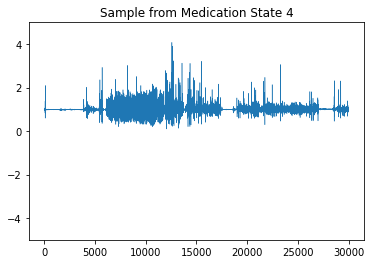

In [38]:
ts_0[9].R.plot(ylim=(-5,5), title='Sample from Medication State 4',linewidth=0.5)

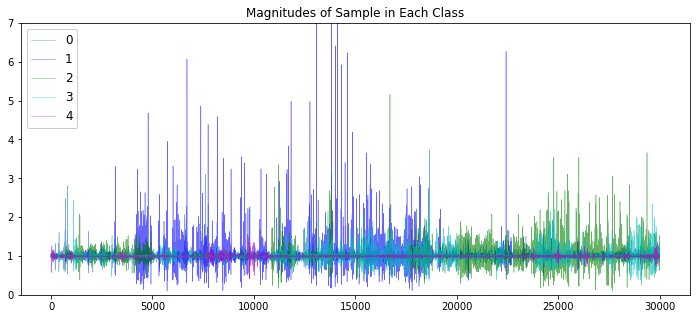

In [39]:
# Plot the magnitude of a time series in each class

fig, ax = plt.subplots(figsize = (12,5), )


ts_0[3].R.plot(ylim = (0,7),ax=ax, alpha = 0.6,
               title='Magnitudes of Sample in Each Class', linewidth=0.5)
ts_1[3].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='b',linewidth=0.5)
ts_2[3].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='g',linewidth=0.5)
ts_3[3].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='c',linewidth=0.5)
ts_4[3].R.plot(ylim = (0,7),ax=ax, alpha = 0.6, color='m',linewidth=0.5)
plt.legend((0,1,2,3,4), loc = 'upper left', fontsize='large', framealpha=1, facecolor='w' );

In [40]:
def R_to_numpy(ts):
    Id = ts.measurement_id
    ts = ts.R.to_numpy()
    ts = (ts, Id)
    return ts

In [41]:
for i, ts in enumerate(ts_0):
    ts_0[i] = R_to_numpy(ts)
    
for i, ts in enumerate(ts_1):
    ts_1[i] = R_to_numpy(ts)
    
for i, ts in enumerate(ts_2):
    ts_2[i] = R_to_numpy(ts)
    
for i, ts in enumerate(ts_3):
    ts_3[i] = R_to_numpy(ts)
    
for i, ts in enumerate(ts_4):
    ts_4[i] = R_to_numpy(ts)

In [42]:
ts_0[0][0]

array([0.98580755, 0.98479695, 0.98436759, ..., 0.98726906, 0.98683571,
       0.98825097])

In [43]:
@jit(nopython=True)
def R_zero_center(ts):
    mean = np.mean(ts[0])
    for i, R in enumerate(ts[0]):
        ts[0][i] = R - mean
    return ts

In [44]:
for i, ts in enumerate(ts_0):
    ts_0[i] = R_zero_center(ts)
    
for i, ts in enumerate(ts_1):
    ts_1[i] = R_zero_center(ts)
    
for i, ts in enumerate(ts_2):
    ts_2[i] = R_zero_center(ts)
    
for i, ts in enumerate(ts_3):
    ts_3[i] = R_zero_center(ts)

for i, ts in enumerate(ts_4):
    ts_4[i] = R_zero_center(ts)

In [45]:
ts_0[0]

(array([-0.00130296, -0.00231357, -0.00274292, ...,  0.00015855,
        -0.00027481,  0.00114046]),
 '5163afe8-a6b0-4ea4-b2ba-9b4501dd5912')

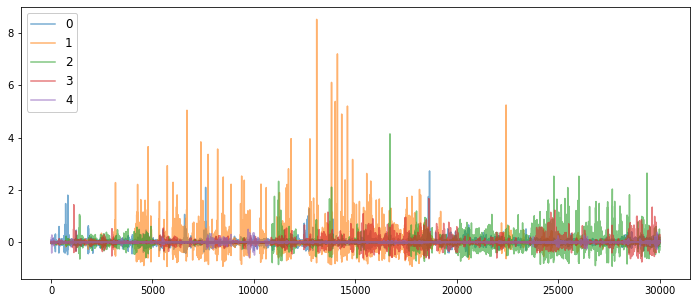

In [46]:
# Plot the magnitude of a time series in each class

fig, ax = plt.subplots(figsize = (12,5), )


plt.plot(ts_0[3][0],alpha=0.6)
plt.plot(ts_1[3][0],alpha=0.6)
plt.plot(ts_2[3][0],alpha=0.6)
plt.plot(ts_3[3][0],alpha=0.6)
plt.plot(ts_4[3][0],alpha=0.6)
plt.legend((0,1,2,3,4), loc = 'upper left', fontsize='large', framealpha=1, facecolor='w' );

# Creating Spectrogram Dataset

In [47]:
# number of mel frequency bands
n_mels = 128
hop_length = 256 
sample_rate = 0.02
n_fft = 2048  # frame length

fmin = 0        
fmax = 0.01# sample_rate/2

AttributeError: 'RendererAgg' object has no attribute 'buffer_rgb'

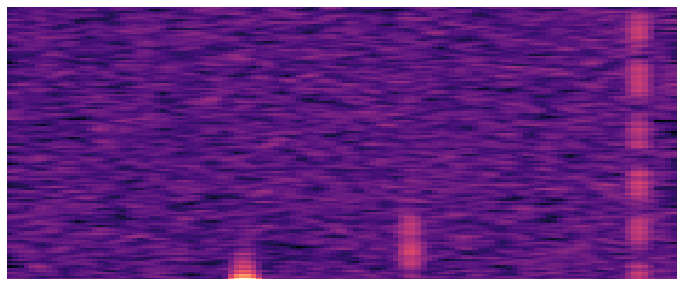

In [67]:
x = ts_0[0][0]
    
fig, ax = plt.subplots( figsize=(12, 5))
    
mel_spec = librosa.feature.melspectrogram(x , n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
    
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax)
fig.patch.set_visible(False)
ax.axis('off')
fig.canvas.draw()
X = np.array(fig.canvas.renderer.buffer_rgba())
plt.close()

In [68]:
X.shape

(360, 864, 4)

In [258]:
    def spec_array(ts, n_mels = 128, hop_length = 256, sample_rate = 0.02,
                 n_fft = 2048, fmin = 0, fmax = 0.01, power=1.0):
        fig, ax = plt.subplots(figsize=(12, 5))
        mel_spec = librosa.feature.melspectrogram(np.array(ts.R), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sample_rate, power=power,
                                              fmin=fmin, fmax=fmax)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                             sr=sample_rate, hop_length=hop_length,fmin=fmin, fmax=fmax, ax=ax)
        
        fig.patch.set_visible(False)
        ax.axis('off')
        fig.canvas.draw()
        X = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close()
        return X

In [267]:
X = spec_array(ts_0[0])

In [269]:
def spec_prep(spec_arr, cropx=670, cropy=272):
    y,x,c = spec_arr.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    spec_arr = spec_arr[starty:starty+cropy, startx:startx+cropx, :]
    spec_arr = spec_arr[:,:,:3]
    return spec_arr

In [271]:
spec_prep(X).shape

(272, 670, 3)

In [319]:
tst_dict = {1:[np.zeros(4),np.zeros(4)], 2: [np.zeros(4),np.zeros(4)]}
tst_dict

{1: [array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
 2: [array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]}

In [320]:
def foo_func(arr):
    arr = np.reshape(arr,(2,2))
    return arr

In [322]:
for key, arr_list in tst_dict.items():
    print(arr_list)
        

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]
[array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]


In [305]:
tst_dict[1][0]

array([[0., 0.],
       [0., 0.]])

In [318]:
tst_dict.items()

dict_items([(1, [array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])]), (2, [array([[0., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 0.]])])])

In [332]:
len(dataset.data_dict[4.0])

718

In [354]:
labels.iloc[1853].tremor.isnan

AttributeError: 'numpy.float64' object has no attribute 'isnan'

In [355]:
np.isnan(labels.iloc[1853].tremor)

True

In [350]:
labels.iloc[1853].tremor == np.nan

False